# Question Answering for Text Classification with Flan-T5
* Binary and multi-class classification


## Requirements

In [ ]:
!pip install transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━

In [ ]:
# Other Requirements
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, f1_score, recall_score, precision_score, ConfusionMatrixDisplay

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

## Loading Data

In [ ]:
edus_dataset = pd.read_excel('Edus+Annotations Data.xlsx')
edus_dataset

NameError: name 'pd' is not defined

In [ ]:
edus_dataset.drop(['Anno_name_x', 'matches', 'Anno_name_y'], axis=1)

NameError: name 'edus_dataset' is not defined

In [ ]:
# Extracting gold labels from Edus dataset
gold_labels_appraisal= []
for i in range(edus_dataset.shape[0]):
  gold_labels_appraisal.append(edus_dataset.iloc[i]["Appraisal?"])

In [ ]:
edus_dataset.shape

## Loading Model and Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## Binary Classification

### Prompting Model for predicting if EDU has or not appraisal (yes/no)


In [ ]:
# Prompt for yes/no appraisal in edus
prompt_YN_appraisal = '''A text can be classified in one of the following two categories:
1. yes: includes an evaluation or assessment of something or someone.
2. no: does not include an evaluation or assessment of something or someone.
Please classify the text given the two categories: yes and no. Use these examples for help. \n\n'''
ex_1 = "Example 1: we condemn. \n" + "Category: " + "yes" + "\n"
ex_2 = "Example 2: That would have extremely significant consequences, first and foremost for the people of Ukraine, of course. \n" + "Category: " + "yes" + "\n"
ex_3=  "Example 3: A clear threat to peace and security is posed. \n" + "Category: " + "yes" + "\n"
ex_4 = "Example 4: and let us stop that decree from being implemented. \n" + "Category: " + "no" + "\n"
ex_5 = "Example 5: and no one has said before that the Council is acting in contravention of the presumption of innocence. \n" + "Category: " + "no" + "\n"
ex_6 = "Example 6: The technical committees. \n" + "Category: " + "no" + "\n"
prompt_YN_app = prompt_YN_appraisal + ex_1 + ex_2 + ex_3 + ex_4 + ex_5 + ex_6
print(prompt_YN_app)

A text can be classified in one of the following two categories:
1. yes: includes an evaluation or assessment of something or someone.
2. no: does not include an evaluation or assessment of something or someone.
Please classify the text given the two categories: yes and no. Use these examples for help. 

Example 1: we condemn. 
Category: yes
Example 2: That would have extremely significant consequences, first and foremost for the people of Ukraine, of course. 
Category: yes
Example 3: A clear threat to peace and security is posed. 
Category: yes
Example 4: and let us stop that decree from being implemented. 
Category: no
Example 5: and no one has said before that the Council is acting in contravention of the presumption of innocence. 
Category: no
Example 6: The technical committees. 
Category: no



In [ ]:
edus_dataset.iloc[0]['Edu Speech']
# Predicting labels
size_dataset = edus_dataset.shape[0]
# n = 2
predicted_labels_Appraisal = []

for i in tqdm(range(size_dataset)):

  input_text = prompt_YN_app + "Example: " + edus_dataset.iloc[i]["Edu Speech"] +  "Category: "
  input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

  outputs = model.generate(input_ids)
  predicted_labels_Appraisal.append(tokenizer.decode(outputs[0][1:-1]))
  predicted_labels_Appraisal = [i.lower() for i in predicted_labels_Appraisal] # lower case of predicted labels

predicted_labels_Appraisal

100%|██████████| 6450/6450 [13:39<00:00,  7.87it/s]


['no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'yes',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'yes',
 'yes',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'yes',
 'yes',
 'yes',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'yes',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 'no',
 '

In [ ]:
# Adding predicted labels to dataframe for yes/no labels for all edus
edus_dataset['Predicted Appraisal-FlanT5-QA'] = predicted_labels_Appraisal
edus_dataset

,Annotated Text,Label,Anno_name_x,matches,Edu Speech,Anno_name_y,Appraisal?,Predicted Appraisal-FlanT5-QA
0,wishes to express its satisfaction,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,Uruguay wishes to express its satisfaction for...,Uruguay wishes to express its satisfaction for...,UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes,no
1,NaN,NaN,NaN,None,(2016).,UNSC_2016_SPV.7643_spch018_ann_Uruguay,no,no
2,we want to thank,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,"At the outset, we want to thank the United Sta...","At the outset, we want to thank the United Sta...",UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes,no
3,is very pleased,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,Uruguay is very pleased to join the rest of th...,Uruguay is very pleased to join the rest of th...,UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes,no
4,problem,appreciation-negative,UNSC_2016_SPV.7643_spch018_ann_Uruguay,that dealing with this problem can no longer b...,that dealing with this problem can no longer b...,UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes,no
...,...,...,...,...,...,...,...,...
6445,NaN,NaN,NaN,None,Let us ensure,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,no,no
6446,criminal decree,appreciation-negative,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,that are currently enshrined in the criminal d...,that are currently enshrined in the criminal d...,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,yes,no
6447,NaN,NaN,NaN,None,and let us stop that decree from being impleme...,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,no,yes
6448,extremely significant consequences,appreciation-negative,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,That would have extremely significant conseque...,That would have extremely significant conseque...,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,yes,yes


In [ ]:
# Unique values of predicted labels column
appraisal_predicted_labels= edus_dataset['Predicted Appraisal-FlanT5-QA'].unique().tolist()
appraisal_predicted_labels

['no', 'yes']

In [ ]:
# Saving file with predicted labels with Flan-T5
edus_dataset.to_csv('Results predictions Appraisal-Flan-T5-QA.csv', index=False)

#### Evaluation for predicted labels for Appraisal (yes/no)

In [ ]:
# Calculating accuracy- Not working check why
accuracy_appraisal = accuracy_score(predicted_labels_Appraisal, gold_labels_appraisal)
print("Accuracy score: {:.2f}".format(accuracy_appraisal*100))

Accuracy score: 63.27


In [ ]:
edus_dataset['Predicted Appraisal-FlanT5-QA'].value_counts()

no     5404
yes    1046
Name: Predicted Appraisal-FlanT5-QA, dtype: int64

In [ ]:
edus_dataset['Appraisal?'].value_counts()

no     3707
yes    2743
Name: Appraisal?, dtype: int64

In [ ]:
# Classification Report - INTERPRET THIS RESULTS
# y_true, y_pred, labels= xxx
print(classification_report(gold_labels_appraisal, predicted_labels_Appraisal))

              precision    recall  f1-score   support

          no       0.62      0.91      0.74      3707
         yes       0.68      0.26      0.37      2743

    accuracy                           0.63      6450
   macro avg       0.65      0.58      0.56      6450
weighted avg       0.65      0.63      0.58      6450



In [ ]:
# Confusion Matrix
# y_true, y_pred, labels= xxx
confusion_matrix_Appraisal = confusion_matrix(gold_labels_appraisal, predicted_labels_Appraisal, labels=['yes', 'no'])

In [ ]:
confusion_matrix_Appraisal

array([[ 710, 2033],
       [ 336, 3371]])

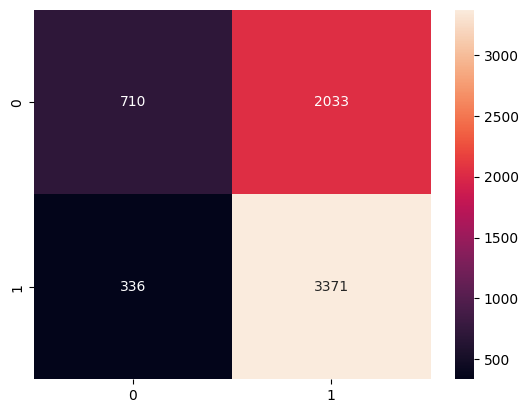

In [ ]:
# CON COLORES MATRIX - Parece que el error aca de los numeros es por que el modelo predijo 3 clases en vez de 2 toca correrlo de nuevo
sns_matrix_att = sns.heatmap(confusion_matrix_Appraisal, annot= True, fmt='g')

In [ ]:
sns_matrix_att.figure.savefig("Conf_mat_Attitude_FlanT5_QA.png")

## Multiclass Classification- Attitude Labels

In [ ]:
# Loading dataset
attitude_dataset = pd.read_excel('Edus+Annotations Only Yes Appraisal Data_withoutDuplicates.xlsx')
attitude_dataset

,Annotated Text,Label,Anno_name_x,Topic_Agenda Item,Edu Speech,Anno_name_y,Appraisal?
0,wishes to express its satisfaction,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,United Nations peacekeeping operations,Uruguay wishes to express its satisfaction for...,UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes
1,we want to thank,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,United Nations peacekeeping operations,"At the outset, we want to thank the United Sta...",UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes
2,is very pleased,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,United Nations peacekeeping operations,Uruguay is very pleased to join the rest of th...,UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes
3,problem,appreciation-negative,UNSC_2016_SPV.7643_spch018_ann_Uruguay,United Nations peacekeeping operations,that dealing with this problem can no longer b...,UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes
4,voted in favour,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,United Nations peacekeeping operations,"For all of those reasons, therefore, Uruguay v...",UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes
...,...,...,...,...,...,...,...
1599,We very much hope,affect-positive,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,Ukraine,We very much hope,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,yes
1600,crisis,appreciation-negative,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,Ukraine,and show the way towards a political solution ...,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,yes
1601,criminal decree,appreciation-negative,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,Ukraine,that are currently enshrined in the criminal d...,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,yes
1602,extremely significant consequences,appreciation-negative,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,Ukraine,That would have extremely significant conseque...,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,yes


In [ ]:
# Extracting gold labels from Edus dataset
gold_labels_attitude= []
for i in range(attitude_dataset.shape[0]):
  gold_labels_attitude.append(attitude_dataset.iloc[i]["Label"])

### Prompting Model to predict Attitude Labels for all Edus with yes label

In [ ]:
# PROMPT FOR ATTITUDE LABELS
prompt_attitude = '''A text can be classified in one of the following categories:
1. affect-positive: refers to positive emotional reactions toward an evaluated entity.
2. affect-negative: refers to negative emotional reactions toward an evaluated entity.
3. appreciation-positive: refers to positive subjective evaluation of people and their actions or behavior.
4. appreciation-negative: refers to negative subjective evaluation of people and their actions or behavior.
5. judgement-positive: refers to positive subjective evaluation of objects, artefacts, processes and states of affairs.
6. judgement-negative: refers to negative subjective evaluation of objects, artefacts, processes and states of affairs.
Please classify the text only considering the given the categories: affect-positive, affect-negative, appreciation-positive, appreciation-negative, judgement-positive and judgement-negative. Use these examples for help. \n\n'''
ex_1_af_pos = "Example 1: We are greatful.\n" + "Category: " + "affect-positive" + "\n"
ex_2_af_neg = "Example 2: Unfortunately.\n" + "Category: " + "affect-negative" + "\n"
ex_3_ap_pos = "Example 3: Dramatic improvement.\n" + "Category: " + "appreciation-positive" +"\n"
ex_4_ap_neg = "Example 4: Catastrophic loss of life.\n" + "Category: " + "appreciation-negative" +"\n"
ex_5_jud_pos = "Example 5: It is the job of this body to stand up for peace and to defend those in danger.\n" + "Category: " + "judgement-positive" + "\n"
ex_6_jud_neg = "Example 6: A clear threat to peace and security is posed.\n" + "Category: " + "judgement-negative" + "\n"
prompt_att = prompt_attitude + ex_1_af_pos + ex_2_af_neg + ex_3_ap_pos + ex_4_ap_neg + ex_5_jud_pos + ex_6_jud_neg
print(prompt_att)

A text can be classified in one of the following categories:
1. affect-positive: refers to positive emotional reactions toward an evaluated entity.
2. affect-negative: refers to negative emotional reactions toward an evaluated entity.
3. appreciation-positive: refers to positive subjective evaluation of people and their actions or behavior.
4. appreciation-negative: refers to negative subjective evaluation of people and their actions or behavior.
5. judgement-positive: refers to positive subjective evaluation of objects, artefacts, processes and states of affairs.
6. judgement-negative: refers to negative subjective evaluation of objects, artefacts, processes and states of affairs.
Please classify the text only considering the given the categories: affect-positive, affect-negative, appreciation-positive, appreciation-negative, judgement-positive and judgement-negative. Use these examples for help. 

Example 1: We are greatful.
Category: affect-positive
Example 2: Unfortunately.
Categor

In [ ]:
attitude_dataset.iloc[0]['Edu Speech']
# Predicting labels
size_dataset = attitude_dataset.shape[0]
# n = 2
predicted_labels_attitude = []

for i in tqdm(range(size_dataset)):

  input_text = prompt_att + "Example: " + attitude_dataset.iloc[i]["Edu Speech"] +  "Category: "
  input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

  outputs = model.generate(input_ids)
  predicted_labels_attitude.append(tokenizer.decode(outputs[0][1:-1]))
  predicted_labels_attitude = [i.lower() for i in predicted_labels_attitude] # lower case of predicted labels

predicted_labels_attitude

  0%|          | 0/1604 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 1604/1604 [05:47<00:00,  4.62it/s]


['appreciation-positive',
 'appreciation-positive',
 'appreciation-positive',
 'judgement-positive',
 'appreciation-positive',
 'judgement-negative',
 'appreciation-positive',
 'judgement-negative',
 'judgement-negative',
 'judgement-negative',
 'judgement-negative',
 'appreciation-positive',
 'judgement-negative',
 'judgement-positive',
 'appreciation-positive',
 'judgement-negative',
 'judgement-positive',
 'judgement-negative',
 'judgement-negative',
 'judgement-positive',
 'judgement-negative',
 'judgement-negative',
 'judgement-negative',
 'judgement-positive',
 'judgement-negative',
 'appreciation-positive',
 'appreciation-positive',
 'judgement-negative',
 'judgement-positive',
 'judgement-negative',
 'appreciation-positive',
 'appreciation-positive',
 'appreciation-positive',
 'appreciation-positive',
 'affect-negative',
 'appreciation-positive',
 'judgement-positive',
 'appreciation-positive',
 'judgement-negative',
 'appreciation-positive',
 'judgement-positive',
 'judgement-

In [ ]:
# Adding predicted labels to dataframe
attitude_dataset['Predicted Attitude Flan-t5-QA'] = predicted_labels_attitude
attitude_dataset

,Annotated Text,Label,Anno_name_x,Topic_Agenda Item,Edu Speech,Anno_name_y,Appraisal?,Predicted Attitude Flan-t5-QA
0,wishes to express its satisfaction,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,United Nations peacekeeping operations,Uruguay wishes to express its satisfaction for...,UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes,appreciation-positive
1,we want to thank,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,United Nations peacekeeping operations,"At the outset, we want to thank the United Sta...",UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes,appreciation-positive
2,is very pleased,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,United Nations peacekeeping operations,Uruguay is very pleased to join the rest of th...,UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes,appreciation-positive
3,problem,appreciation-negative,UNSC_2016_SPV.7643_spch018_ann_Uruguay,United Nations peacekeeping operations,that dealing with this problem can no longer b...,UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes,judgement-positive
4,voted in favour,affect-positive,UNSC_2016_SPV.7643_spch018_ann_Uruguay,United Nations peacekeeping operations,"For all of those reasons, therefore, Uruguay v...",UNSC_2016_SPV.7643_spch018_ann_Uruguay,yes,appreciation-positive
...,...,...,...,...,...,...,...,...
1599,We very much hope,affect-positive,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,Ukraine,We very much hope,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,yes,affect-positive
1600,crisis,appreciation-negative,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,Ukraine,and show the way towards a political solution ...,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,yes,judgement-positive
1601,criminal decree,appreciation-negative,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,Ukraine,that are currently enshrined in the criminal d...,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,yes,judgement-negative
1602,extremely significant consequences,appreciation-negative,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,Ukraine,That would have extremely significant conseque...,UNSC_2014_SPV.7154_spch021_ann_Russian_Federation,yes,judgement-positive


In [ ]:
attitude_dataset['Predicted Attitude Flan-t5-QA'].value_counts()

judgement-negative       628
appreciation-positive    486
judgement-positive       295
affect-negative          171
affect-positive           21
appreciation-negative      3
Name: Predicted Attitude Flan-t5-QA, dtype: int64

In [ ]:
# Saving file with predicted labels with Flan-T5
attitude_dataset.to_excel('Results predictions Attitude Google-Flan-T5.xlsx', index=False)

#### Evaluation of predicted labels for Attitude labels (aff, app, judg)

In [ ]:
attitude_labels = ['affect-positive', 'affect-negative', 'appreciation-positive', 'appreciation-negative', 'judgement-positive', 'judgement-negative']

In [ ]:
# Calculating accuracy-
accuracy_attitude = accuracy_score(predicted_labels_attitude, gold_labels_attitude)
print("Accuracy score: {:.2f}".format(accuracy_attitude*100))

Accuracy score: 36.03


In [ ]:
# Classification Report - INTERPRET THIS RESULTS
# y_true, y_pred, labels= xxx
print(classification_report(gold_labels_attitude, predicted_labels_attitude))

                       precision    recall  f1-score   support

      affect-negative       0.32      0.36      0.34       148
      affect-positive       0.67      0.05      0.09       279
appreciation-negative       0.00      0.00      0.00       338
appreciation-positive       0.14      0.61      0.23       109
   judgement-negative       0.62      0.70      0.66       553
   judgement-positive       0.19      0.31      0.23       177

             accuracy                           0.36      1604
            macro avg       0.32      0.34      0.26      1604
         weighted avg       0.39      0.36      0.32      1604



In [ ]:
# Confusion Matrix
# y_true, y_pred, labels= xxx
confusion_matrix_Attitude = confusion_matrix(gold_labels_attitude, predicted_labels_attitude, labels=attitude_labels)

In [ ]:
confusion_matrix_Attitude

array([[ 58,   0, 255,   0,  33,   8],
       [  6,  81,  17,   2,   8,  69],
       [  0,   1,  67,   1,  32,   8],
       [  6,  64, 103,   0, 215, 219],
       [  0,   2, 113,   0,  56,  11],
       [ 18, 202,  42,   0, 251, 795]])

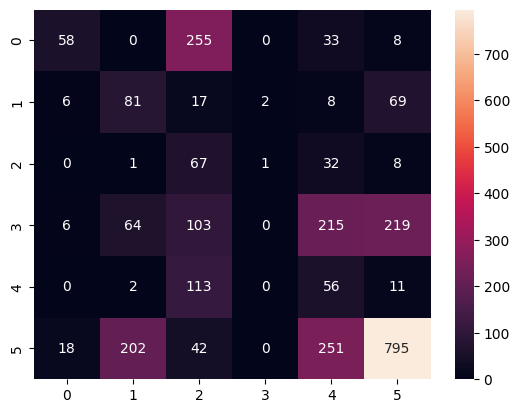

In [ ]:
# CON COLORES MATRIX - Parece que el error aca de los numeros es por que el modelo predijo 3 clases en vez de 2 toca correrlo de nuevo
sns_matrix_att = sns.heatmap(confusion_matrix_Attitude, annot= True, fmt='g')

In [ ]:
sns_matrix_att.figure.savefig("Conf_mat_Attitude_BART_ZSC.png")